In [ ]:
pip install numpy

In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, optimizers

import math
import numpy as np
import os

In [ ]:
# Load data from an Excel file
print(os.listdir())
data = pd.read_excel('HotQCD Data(2).xlsx', sheet_name='HotQCD')  # Adjust 'Sheet1' if your data is on a different sheet
T_data = data['T'].values  # Temperature values
S_true_data = data['S'].values  # True entropy density values
TA_true_data = data['TA'].values  # True trace anomaly values
P_true_data = data['P'].values  # True pressure values
Ed_true_data = data['Ed'].values  # True energy density values

data = pd.read_excel('HotQCD Data(2).xlsx', sheet_name='WB Lattice')  # Adjust 'Sheet1' if your data is on a different sheet
T_data_2 = data['T'].values  # Temperature values
S_true_data_2 = data['S'].values  # True entropy density values
TA_true_data_2 = data['TA'].values  # True trace anomaly values

data = pd.read_excel('HotQCD Data(2).xlsx', sheet_name='HotQCD Predicted')  # Adjust 'Sheet1' if your data is on a different sheet
T_data_3 = data['T'].values  #  values
S_pred_data = data['S'].values  # True entropy density values
TA_pred_data = data['TA'].values  # True trace anomaly values
P_pred_data = data['P'].values  # True pressure values
Ed_pred_data = data['Ed'].values  # True energy density values

['.config', 'HotQCD Data(1).xlsx', 'model_m_s_weights.weights.h5', 'model_m_g_weights.weights.h5', 'HotQCD Data(2).xlsx', 'HotQCD Data.xlsx', 'model_m_ud_weights.weights.h5', 'sample_data']


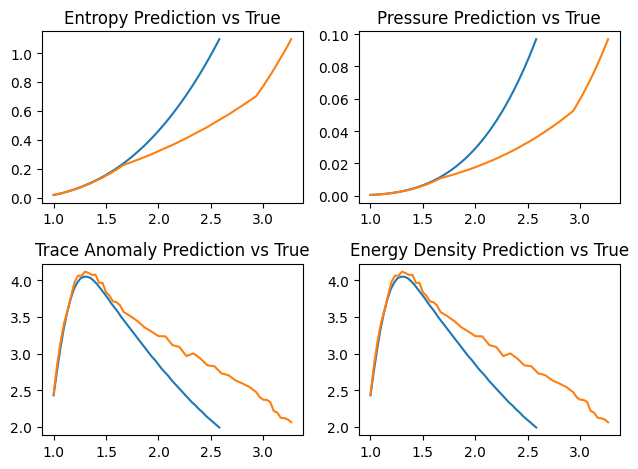

In [ ]:
T_c = T_data[0]
T_norm = T_data/T_c

T_c_2 = T_data_2[0]
T_norm_2 = T_data_2/T_c_2

fig, axs = plt.subplots(2, 2)

axs[0][0].plot(T_norm, S_true_data, label="True")
axs[0][0].plot(T_norm_2, S_pred_data, label="Predicted")
axs[0][0].set_title("Entropy Prediction vs True")

axs[1][0].plot(T_norm, TA_true_data, label="True")
axs[1][0].plot(T_norm_2, TA_pred_data, label="Predicted")
axs[1][0].set_title("Trace Anomaly Prediction vs True")

axs[0][1].plot(T_norm, P_true_data, label="True")
axs[0][1].plot(T_norm_2, P_pred_data, label="Predicted")
axs[0][1].set_title("Pressure Prediction vs True")

axs[1][1].plot(T_norm, TA_true_data, label="True")
axs[1][1].plot(T_norm_2, TA_pred_data, label="Predicted")
axs[1][1].set_title("Energy Density Prediction vs True")

plt.tight_layout()

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

epochs = 500  # Number of training epochs
batch_size = 50  # Batch size

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

tf.keras.backend.set_floatx('float64')

# Convert data to TensorFlow format
T_data = tf.convert_to_tensor(T_data, dtype=tf.float64)
S_true_data = tf.convert_to_tensor(S_true_data, dtype=tf.float64)
TA_true_data = tf.convert_to_tensor(TA_true_data, dtype=tf.float64)

T_data_np = T_data.numpy()
S_true_data_np = S_true_data.numpy()
TA_true_data_np = TA_true_data.numpy()

# Split into training and temporary (validation + test) sets
T_train, T_temp, S_train, S_temp, TA_train, TA_temp = train_test_split(
    T_data_np, S_true_data_np, TA_true_data_np, test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets
T_val, T_test, S_val, S_test, TA_val, TA_test = train_test_split(
    T_temp, S_temp, TA_temp, test_size=0.5, random_state=42)

N_f = 3 # Number of Quark Flavors being considered. u-quark, d-quark, s-quark = 3
N_c = 3 # Number of Color Charges. Red, Blue, Green = 3.
m_s_bar = 0.095 # Current Mass of a Strange Quark, in MeV
m_ud_bar = 0.005 # Current Mass of Up and Down Quarks, in MeV

R_gq = math.sqrt((3/2)*(N_c/3 + N_f/6))

def calculate_L_2(m_ud, m_s):
    """
    Calculates Second Mass Constraint L_2.

    Parameters
    ----------
    m_ud : float
        Mass of Up/Down Quarks
    m_s  : float
        Mass of Strange Quarks

    Returns
    -------
    float
        The Second Mass Constraint of the Mass Constraint Loss Function
    """
    m_s = tf.cast(m_s, dtype=tf.float64)
    m_ud = tf.cast(m_ud, dtype=tf.float64)
    return tf.convert_to_tensor(abs((m_s - m_ud)/(m_s_bar - m_ud_bar) - 1), dtype=tf.float64)

def create_mass_model(input_shape):
    model = models.Sequential()

    # Input layer
    model.add(layers.InputLayer(shape=input_shape))

    # Hidden layers (same structure across all models)
    for _ in range(8):  # 8 hidden layers
        model.add(layers.Dense(32, activation='swish'))

    # Output layer for the mass function
    model.add(layers.Dense(1, activation='sigmoid'))

    # Ensure the output is a rank-1 tensor
    model.add(layers.Lambda(lambda x: tf.squeeze(x, axis=-1)))

    return model

# Define models for each mass function
input_shape = (1,)  # Temperature as a single input
model_m_ud = create_mass_model(input_shape)
model_m_s = create_mass_model(input_shape)
model_m_g = create_mass_model(input_shape)

# Combine outputs from each model
def quasi_particle_model(T):
    m_ud = model_m_ud(T)
    m_s = model_m_s(T)
    m_g = model_m_g(T)

    print("Up/Down Mass:")
    print(m_ud)
    print("Strange Mass:")
    print(m_s)
    print("Gluon Mass:")
    print(m_g)
    return m_ud, m_s, m_g

def gauss_quad_integral(integrand, T, m, n=25):
    # n -> number of gauss quadrature points

    # Precompute Gaussian-Laguerre quadrature points and weights for the interval [0, inf)
    # Use numpy to get the points and weights, then convert them to TensorFlow constants
    points, weights = np.polynomial.laguerre.laggauss(n)
    points_tf = tf.constant(points, dtype=tf.float64)
    weights_tf = tf.constant(weights, dtype=tf.float64)

     # Compute integrand for each T separately
    results = []

    for i in range(len(T)):
        T_i_tf = tf.constant(T[i], dtype=tf.float64)
        m_i_tf = tf.cast(m[i], dtype=tf.float64)

        # Compute integrand values
        integrand_values = integrand(points_tf, T_i_tf, m_i_tf) / tf.exp(-points_tf)
        integral_result = tf.reduce_sum(weights_tf * integrand_values)
        results.append(integral_result)

    return tf.stack(results)


def calculate_lnZg(p, T, m_g):
    """
    Calculates the log partition function lnZ of a system of gluons at a given temperature T and mass m_g.

    Parameters
    ----------
    T   : float
        Temperature
    m_g : float
        Gluon Mass

    Returns
    -------
    float
        Log partition function lnZ
    """
    p = tf.cast(p, dtype=tf.float64)
    m_g = tf.cast(m_g, dtype=tf.float64)
    pi_squared = tf.constant(3.1416 ** 2, dtype=tf.float64)
    exp_term = (-1)/(T)*tf.math.sqrt(tf.square(p) + tf.square(m_g))
    log_term = tf.math.log1p((-1)*tf.clip_by_value(tf.math.exp(exp_term), 1e-30, 1.0))
    factor = tf.constant(-16.0 / (2.0 * pi_squared), dtype=tf.float64)
    return (factor)*(tf.square(p))*(log_term)

def calculate_lnZq(p, T, m_q):
    """
    Calculates the log partition function lnZ of a system of quarkss at a given temperature T and mass m_q.

    Parameters
    ----------
    T   : float
        Temperature
    m_q : float
        Quark Mass

    Returns
    -------
    float
        Log partition function lnZ
    """
    p = tf.cast(p, dtype=tf.float64)
    m_q = tf.cast(m_q, dtype=tf.float64)
    pi_squared = tf.constant(3.1416 ** 2, dtype=tf.float64)
    exp_term = (-1)/(T)*tf.math.sqrt(tf.square(p) + tf.square(m_q))
    log_term = tf.math.log1p(tf.clip_by_value(tf.math.exp(exp_term), 1e-30, 1.0))
    factor = tf.constant(12.0 / (2.0 * pi_squared), dtype=tf.float64)
    return (factor)*(tf.square(p))*(log_term)

def calculate_S_TA(T, m_ud, m_s, m_g):
    print("Temperature:")
    print(T)

    lnZ_ud = gauss_quad_integral(calculate_lnZq, T, m_ud)
    lnZ_s = gauss_quad_integral(calculate_lnZq, T, m_s)
    lnZ_g = gauss_quad_integral(calculate_lnZg, T, m_g)

    print("lnZ Up/Down")
    print(lnZ_ud)
    print("lnZ Strange")
    print(lnZ_s)
    print("lnZ Gluon")
    print(lnZ_g)

    # Compute pressure P(T) and energy density ε(T)
    P_ud = T*lnZ_ud
    P_s = T*lnZ_s
    P_g = T*lnZ_g

    #print("Pressure Up/Down")
    #print(P_ud)
    #print("Pressure Strange")
    #print(P_s)
    #print("Pressure Gluon")
    #print(P_g)

    # Use GradientTape to compute the gradients for energy densities
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(T)
        lnZ_ud = gauss_quad_integral(calculate_lnZq, T, m_ud)
        lnZ_s = gauss_quad_integral(calculate_lnZq, T, m_s)
        lnZ_g = gauss_quad_integral(calculate_lnZg, T, m_g)

    Ed_ud = (T**2)*(tape.gradient(lnZ_ud, T))
    Ed_s = (T**2)*(tape.gradient(lnZ_s, T))
    Ed_g = (T**2)*(tape.gradient(lnZ_g, T))

    # Debugging
    #print("Energy Density Up/Down")
    #print(Ed_ud)
    #print("Energy Density Strange")
    #print(Ed_s)
    #print("Energy Density Gluon")
    #print(Ed_g)

    # Release resources held by tape
    del tape

    P_tot = P_ud + P_s + P_g
    Ed_tot = Ed_ud + Ed_s + Ed_g

    # Debugging
    print("Total Pressure:")
    print(P_tot)
    print("Total Energy Density:")
    print(Ed_tot)

    # Calculate entropy density and trace anomaly
    S = (Ed_tot + P_tot)/T
    TA = (Ed_tot - 3*P_tot)/(T**4)

    # Debugging final outputs
    print("Entropy:")
    print(S)
    print("Trace Anomaly:")
    print(TA)

    return S, TA

# Loss Function. Implemented as laid out by the paper:
# L = (s_true^2 - s_pred^2) + (ta_true^2 - ta_pred^2) + LMC
def loss_function(T, S_true, TA_true, beta1=0.1, beta2=0.0075):
    # Get masses from the models
    m_ud, m_s, m_g = quasi_particle_model(T)

    # Compute entropy density and trace anomaly
    S_pred, TA_pred = calculate_S_TA(T, m_ud, m_s, m_g)

    # Calculate RMSE
    S_rmse = tf.square(S_true - S_pred)
    TA_rmse = tf.square(TA_true - TA_pred)

    # Physical constraints, e.g., mg > mu_d > ms at high temperatures
    # These would depend on ratios or values at certain temperature cutoffs
    L_1 = tf.convert_to_tensor(abs(R_gq - (3/2)), dtype=tf.float64) # First Mass Constraint
    L_2 = calculate_L_2(m_ud, m_s)  # Second Mass Constraint

    # Weighting of physical constraints
    L_MC = tf.square(beta1*L_1 + beta2*L_2)

    # Final loss function with RMSE and constraints
    total_loss = S_rmse + TA_rmse + L_MC
    total_loss = tf.reduce_mean(total_loss)
    return total_loss

def train_step(T, S_true, TA_true):
    with tf.GradientTape() as tape:
        loss = loss_function(T, S_true, TA_true)

    if tf.reduce_any(tf.math.is_nan(loss)):
      print("NaN encountered in loss calculation.")
      print(f"T_batch: {T.numpy()}")
      print(f"S_true_batch: {S_true.numpy()}")
      print(f"TA_true_batch: {TA_true.numpy()}")

      # Compute intermediate outputs
      m_ud, m_s, m_g = quasi_particle_model(T)
      print(f"m_ud: {m_ud.numpy()}, m_s: {m_s.numpy()}, m_g: {m_g.numpy()}")

      S_pred, TA_pred = calculate_S_TA(T, m_ud, m_s, m_g)
      print(f"S_pred: {S_pred.numpy()}, TA_pred: {TA_pred.numpy()}")

      raise ValueError("NaN encountered in loss computation. Check intermediate outputs.")

    # Compute gradients and apply optimization step
    gradients = tape.gradient(loss, model_m_ud.trainable_variables + model_m_s.trainable_variables + model_m_g.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_m_ud.trainable_variables + model_m_s.trainable_variables + model_m_g.trainable_variables))

    return loss

# Combine data into a TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((T_data, S_true_data, TA_true_data))

# Shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(T_data)).batch(batch_size)

# Convert training data to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((T_train, S_train, TA_train)).shuffle(len(T_train)).batch(batch_size)

# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((T_val, S_val, TA_val)).batch(batch_size)

# Test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((T_test, S_test, TA_test)).batch(batch_size)

# Training loop
for epoch in range(epochs):
    train_losses = []
    # Shuffle data and create batches
    for T_batch, S_true_batch, TA_true_batch in train_dataset:
        loss = train_step(T_batch, S_true_batch, TA_true_batch)
        train_losses.append(loss.numpy())

    # Validation
    val_losses = []
    for T_batch, S_batch, TA_batch in val_dataset:
        val_loss = loss_function(T_batch, S_batch, TA_batch)
        val_losses.append(val_loss.numpy())

    # Print loss at each epoch
    print(f"Epoch {epoch + 1}, Loss: {np.mean(train_losses)}, Validation Loss: {np.mean(val_losses)}")

# Save model weights after training
model_m_ud.save_weights('model_m_ud_weights.weights.h5')
model_m_s.save_weights('model_m_s_weights.weights.h5')
model_m_g.save_weights('model_m_g_weights.weights.h5')

# Load weights if needed
# model_m_ud.load_weights('model_m_ud_weights.h5')
# model_m_s.load_weights('model_m_s_weights.h5')
# model_m_g.load_weights('model_m_g_weights.h5')

# Create a temperature range
temperatures = np.linspace(min(T_data), max(T_data), num=50).reshape(-1, 1)

# Predict masses
m_ud_predictions = model_m_ud.predict(temperatures)
m_s_predictions = model_m_s.predict(temperatures)
m_g_predictions = model_m_g.predict(temperatures)

print("Up-Down Mass:")
print(m_ud_predictions)
print("Strange Mass:")
print(m_s_predictions)
print("Gluon Mass:")
print(m_g_predictions)

Streaming output truncated to the last 5000 lines.
 0.205 0.23  0.39  0.255 0.245 0.345 0.155 0.215 0.335 0.27  0.32  0.385
 0.175 0.225 0.265 0.18 ], shape=(40,), dtype=float64)
lnZ Up/Down
tf.Tensor(
[0.0043431  0.00827996 0.00228011 0.0182588  0.01712321 0.01150317
 0.00208206 0.00374264 0.01213619 0.03474655 0.0034644  0.00189605
 0.02795223 0.03008614 0.02090699 0.04803587 0.00320042 0.03235522
 0.00978966 0.00295037 0.006112   0.01280995 0.02596348 0.01431348
 0.00403544 0.00572689 0.04250751 0.00781326 0.00693013 0.0224414
 0.00172167 0.00466587 0.01951607 0.00926693 0.01609609 0.03983726
 0.00249058 0.00535759 0.00876419 0.00271388], shape=(40,), dtype=float64)
lnZ Strange
tf.Tensor(
[0.00433368 0.00821724 0.00227243 0.01824999 0.01713054 0.01145295
 0.00207192 0.00373787 0.01209712 0.03430129 0.00346083 0.00188307
 0.02761209 0.02968814 0.02082653 0.04817828 0.00319732 0.03191918
 0.00972203 0.00294703 0.00607863 0.01278385 0.02569175 0.01431345
 0.00402873 0.00569947 0.042275